In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# %config InlineBackend.figure_format='retina'

In [2]:
volatile_species = ["H2", "CO", "CO2", "H2O", "CH4", "N2", "O2", "S", "He"]
OPTIONS = {
    "steady_dprel" : 3.0e-10,
    "steady_flux":   2.0,
    "F_crit":        0.1,
    "steady_check":  15
}

In [3]:
def check_iter(df):
    # How many iterations to look backwards
    lb1 = int(-1 * OPTIONS["steady_check"])
    lb2 = -1

    arr_t = np.array(df["Time"])
    arr_f = np.array(df["F_atm"])

    arr_p = np.array(df["Phi_global"])

    # Time samples
    t1 = arr_t[lb1]
    t2 = arr_t[lb2]

    # Check flux value
    flx_m = max(abs(arr_f[lb1]),abs(arr_f[lb2]))

    # Check flux rate
    flx_1 =  arr_f[lb1]
    flx_2 =  arr_f[lb2]
    flx_r = abs(flx_2 - flx_1) / (t2 - t1)

    # Check melt fraction rate
    phi_1 =  arr_p[lb1]
    phi_2 =  arr_p[lb2]
    phi_r = abs(phi_2 - phi_1) / (t2 - t1)

    # Stop?
    stop = False
    if (flx_m < OPTIONS["steady_flux"]) and (phi_r < OPTIONS["steady_dprel"]): #and (flx_r < OPTIONS["steady_dfrel"]):
        stop = True

    return flx_m, flx_r, phi_r, stop

In [4]:
mdf = pd.read_csv("../output/ltt3780b_v3/case_00001/runtime_helpfile.csv",delimiter=r'\s+')
mdf.keys()
npoints = len(mdf)
print(npoints, "points")

497 points


In [5]:
t = []
f = []
s = []
fr = []
pr = []
for i in range(OPTIONS["steady_check"]+1, npoints-1, 1):
    tdf = mdf[:i]

    t.append(tdf.iloc[-1]["Time"])

    f_this, fr_this, pr_this, s_this = check_iter(tdf)
    fr.append(fr_this)
    pr.append(pr_this)
    f.append(f_this)
    if s_this:
        s.append(1.0)
    else:
        s.append(0.0)

f  = np.array(f)
fr = np.array(fr)
s  = np.array(s)
pr = np.array(pr)

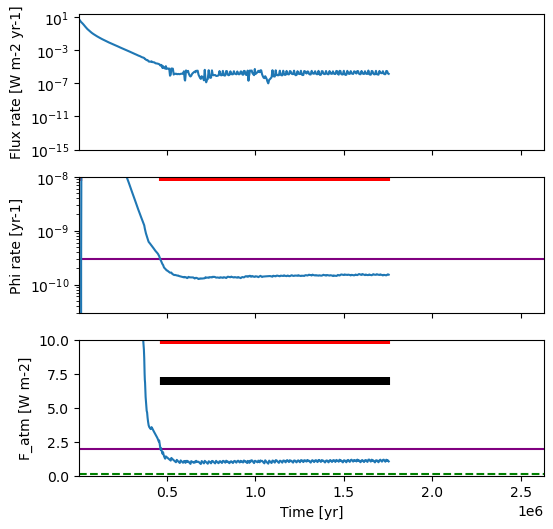

Final flux: 1.052734


In [6]:
fig,(ax0, ax1, ax2) = plt.subplots(3,1, sharex=True, figsize=(6,6))

is_steady = np.argwhere(np.array(s) > 0.999)

ax0.plot(t,fr)
ax0.set_yscale("log"); ax0.set_ylabel("Flux rate [W m-2 yr-1]"); ax0.set_ylim(1.0e-15, np.amax(fr)*5.0)

ax1.axhline(y=OPTIONS["steady_dprel"], color='purple')
ax1.plot(t,pr)
this_steady = np.argwhere(pr < OPTIONS["steady_dprel"])
ax1.scatter(np.array(t)[this_steady], np.full(len(t),1e-8)[this_steady], color='red', marker='|')
ax1.set_yscale("log"); ax1.set_ylabel("Phi rate [yr-1]")
ax1.set_ylim(bottom=OPTIONS["steady_dprel"]/10, top = 1e-8)

ax2.axhline(y=OPTIONS["steady_flux"], color='purple')
ax2.axhline(y=OPTIONS["F_crit"], color='green', linestyle='dashed')
ax2.plot(t,f)
this_steady = np.argwhere(f < OPTIONS["steady_flux"])
ax2.scatter(np.array(t)[this_steady], np.full(len(t),10.0)[this_steady], color='red', marker='|')
ax2.scatter(np.array(t)[is_steady], np.full(len(t),7.0)[is_steady], color='black', marker='|')
ax2.set_xlim(max(1.0, np.amin(t)), np.amax(t)*1.5)
ax2.set_ylabel("F_atm [W m-2]")
ax2.set_xlabel("Time [yr]")
ax2.set_ylim(0.0,10.0)

plt.show()

print("Final flux:",f[-1])